In [39]:
import pandas as pd
import numpy as np
import xarray as xr
import scipy as sp
import scipy.ndimage as ndimage
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr
import random
from itertools import groupby



In [40]:
#Load in the cluster data
df = pd.read_csv("C:/Users/CoeFamily/Documents/David College Class Work/WT_analysis/Coe_clusters_new.csv")
df.columns = ["C","Clust"]
vals = df["Clust"].values
clustvals = list(map(int,vals))
ldf = clustvals

In [41]:
#Load in the temperature dataset
temps = xr.open_dataset("C:/Users/CoeFamily/Documents/David College Class Work/WT_analysis/Temps/era5_temps.nc")
my_file = open("C:/Users/CoeFamily/Downloads/dates_heatwaves.txt", "r")
hw_days = my_file.read().splitlines()

In [42]:
import datetime
start =  datetime.date(1979, 9, 1)
end = datetime.date(2018, 12, 1)
current = start
dates = []
while current <= end:
    if(current.month in [9,10,11] ):
        dates.append(current.strftime("%Y%m%d"))
    current += datetime.timedelta(days=1)

In [43]:
#Now that we have the dates, get the indices associated with each WT
index = []
cluster = []
for date in hw_days:
    ind = dates.index(date)
    index.append(ind)
    cluster.append(ldf[ind])

In [44]:
#Now loop through the indices and put the data into overall arrays by WT
overall_heatwavedays = np.zeros((7,81,121))

for clust, ind in zip(cluster,index):
    temp = np.zeros((81,121))
    for i in range(24):
        ind_new = (ind - 1) * 24 + i
        t = ((temps.t2m[ind_new,:,:].values - 273.15) * (9/5)) + 32
        t[t < 85] = 0
        t[t >= 85] = 1
        temp += t
    temp[temp >= 1] = 1
    overall_heatwavedays[clust-1,:,:] += temp

In [45]:
from netCDF4 import Dataset
lats = Dataset("C:/Users/CoeFamily/Documents/David College Class Work/WT_analysis/Temps/era5_temps.nc").variables['latitude'][:]
lons = Dataset("C:/Users/CoeFamily/Documents/David College Class Work/WT_analysis/Temps/era5_temps.nc").variables['longitude'][:]
LON, LAT = np.meshgrid(lons, lats)

In [46]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gs



def make_grid(rows = 0, cols = 0, proj = ccrs.PlateCarree(),cbar=False):
    axlist = []
    fig2 = plt.figure(figsize=(20, 20))
    if(cbar==False):
        spec2 = gs.GridSpec(ncols=cols, nrows=rows, figure=fig2)

        for x in range(rows):
            for y in range(cols):
                axlist.append(fig2.add_subplot(spec2[x, y], projection=proj))
    else:
        spec2 = gs.GridSpec(ncols=cols + 1, nrows=rows, figure=fig2)

        for x in range(rows):
            for y in range(cols):
                axlist.append(fig2.add_subplot(spec2[x, y], projection=proj))

        axlist.append(fig2.add_subplot(spec2[:,3]))

    return axlist

C:\Users\CoeFamily\.conda\envs\meteorology\lib\site-packages\cartopy\mpl\geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


<Figure size 576x576 with 0 Axes>

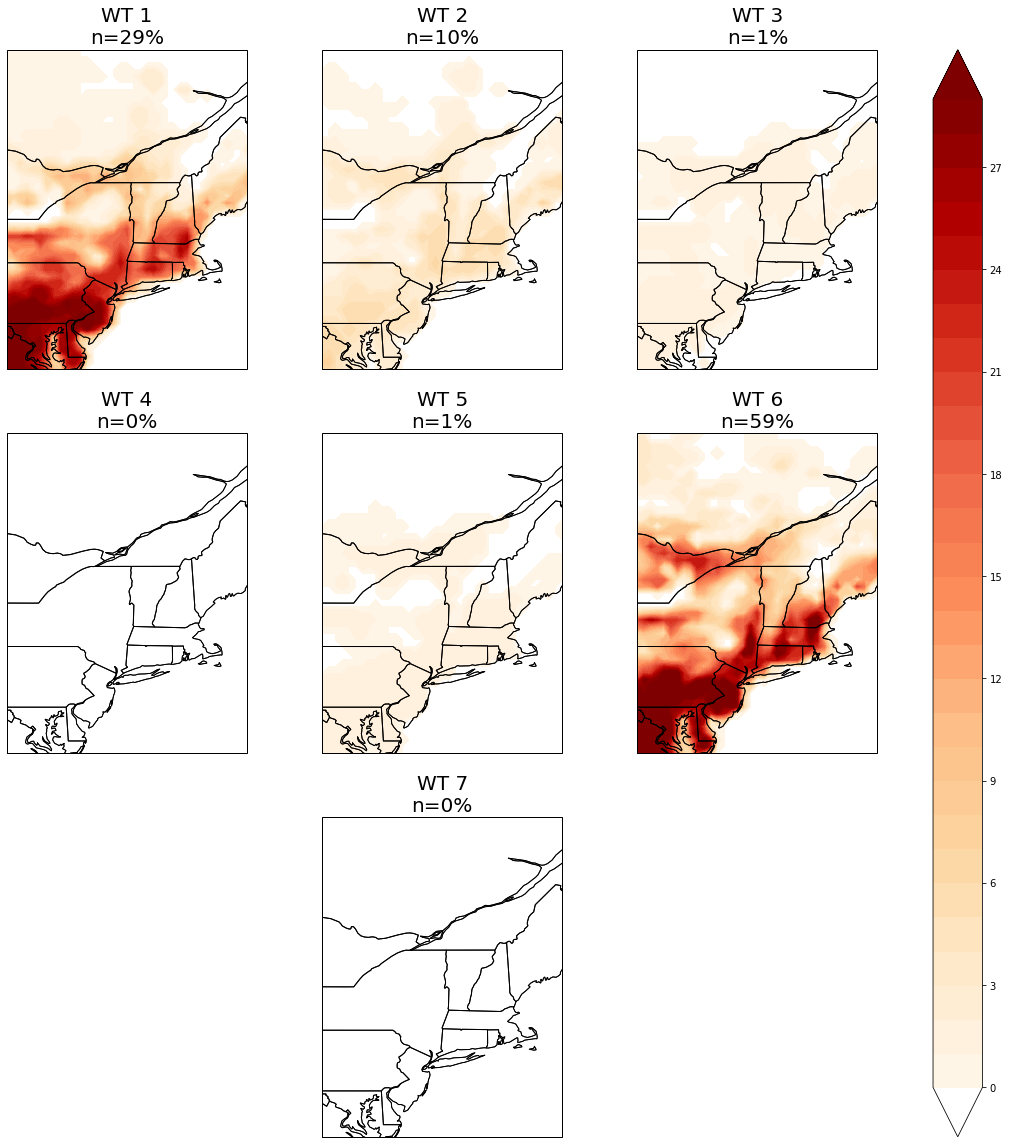

In [47]:
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from copy import copy
fig = plt.figure(figsize=(8, 8))
i = 1

#percents for labels
percents = []
[percents.append((round(cluster.count(a)/len(cluster)*100,0))) for a in range(1,8) ]

axlist = make_grid(3,3,cbar=False)
while i <= 7:
    # WT = precip_data[[j for j, val in enumerate(flat_list) if val == i]]
    # LON2, LAT2 = np.meshgrid(lons2, lats2)
    if(i != 7):
        ax = axlist[i-1]
    else:
        ax = axlist[i]
    ax.set_extent([-78, -69, 38, 50])
    ylocs = np.arange(30, 50, 5)
    xlocs = np.arange(280, 300, 10)

    # Load in the data using xarray

    #overall_heatwavedays[overall_heatwavedays == 0] = np.nan
    palette = copy(plt.get_cmap('OrRd'))
    palette.set_under('white', 1.0)
    cs = ax.contourf(LON, LAT, overall_heatwavedays[i-1,:,:], levels = np.arange(0,30,1), extend = 'both', cmap=palette, transform=ccrs.PlateCarree())
    
    states = NaturalEarthFeature(category = 'cultural',
                     scale = '50m',
                     facecolor = 'none',
                     name = 'admin_1_states_provinces_shp')
    ax.add_feature(states,linewidth=1.,edgecolor="black")
    ax.coastlines('50m',linewidth=0.8)
    #ax.gridlines(linestyle='dotted', ylocs=lats[::20], xlocs=lons[::20])


    if(i == 1):
        wtt = 1
    elif(i == 2):
        wtt = 2
    elif( i == 3):
        wtt = 3
    elif(i == 4):
        wtt = 4
    elif(i == 5):
        wtt = 5
    elif( i == 6):
        wtt = 6
    else:
        wtt = 7
        
    #plt.rc('text', usetex=True)
    tit1 = 'WT ' + str(wtt)
    tit2 = "n=" + str(int(percents[i-1])) + "%"
    #title = r'\fontsize{20pt}{3em}\selectfont{}{WT\r}{\fontsize{18pt}{3em}\selectfont{}(September 16 - October 30, 2012)}'
    title = tit1 + "\n" + tit2
    ax.set_title(title, fontsize=20)
    i += 1
plt.colorbar(cs, ax=axlist[:], orientation='vertical', shrink=1.0)
axlist[6].set_visible(False)
axlist[8].set_visible(False)
plt.savefig('heatwave_heatmap.png',bbox_inches='tight')

In [48]:
#Open the precipitation dataset
precip = xr.open_dataset("C:/Users/CoeFamily/Documents/David College Class Work/WT_analysis/Teleconnections/son_precip.nc").tp.coarsen(time=24).sum()

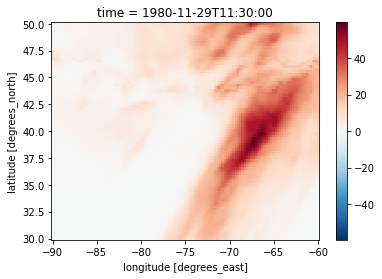

In [58]:
precip = precip * 1000

In [50]:
import datetime
start =  datetime.date(1983, 9, 1)
end = datetime.date(2014, 12, 1)
current = start
dates = []
while current <= end:
    if(current.month in [9,10,11] ):
        dates.append(current.strftime("%Y%m%d"))
    current += datetime.timedelta(days=1)

In [51]:
my_file = open("C:/Users/CoeFamily/Downloads/dates_xprec.txt", "r")
xp_days = my_file.read().splitlines()
ldf = clustvals[364:]
#Now that we have the dates, get the indices associated with each WT
index = []
cluster = []
for date in xp_days:
    try:
        ind = dates.index(date)
        index.append(ind)
        cluster.append(ldf[ind])
    except:
        pass

In [59]:
#Now loop through the indices and put the data into overall arrays by WT
overall_xpdays = np.zeros((7,81,121))

for clust, ind in zip(cluster,index):
    temp = np.zeros((81,121))
    xp_prec = precip[ind,:,:].copy().data
    np.nan_to_num(xp_prec, copy=False)

    xp_prec[xp_prec < 20] = 0
    xp_prec[xp_prec >= 20] = 1  
    overall_xpdays[clust-1,:,:] += xp_prec

<Figure size 576x576 with 0 Axes>

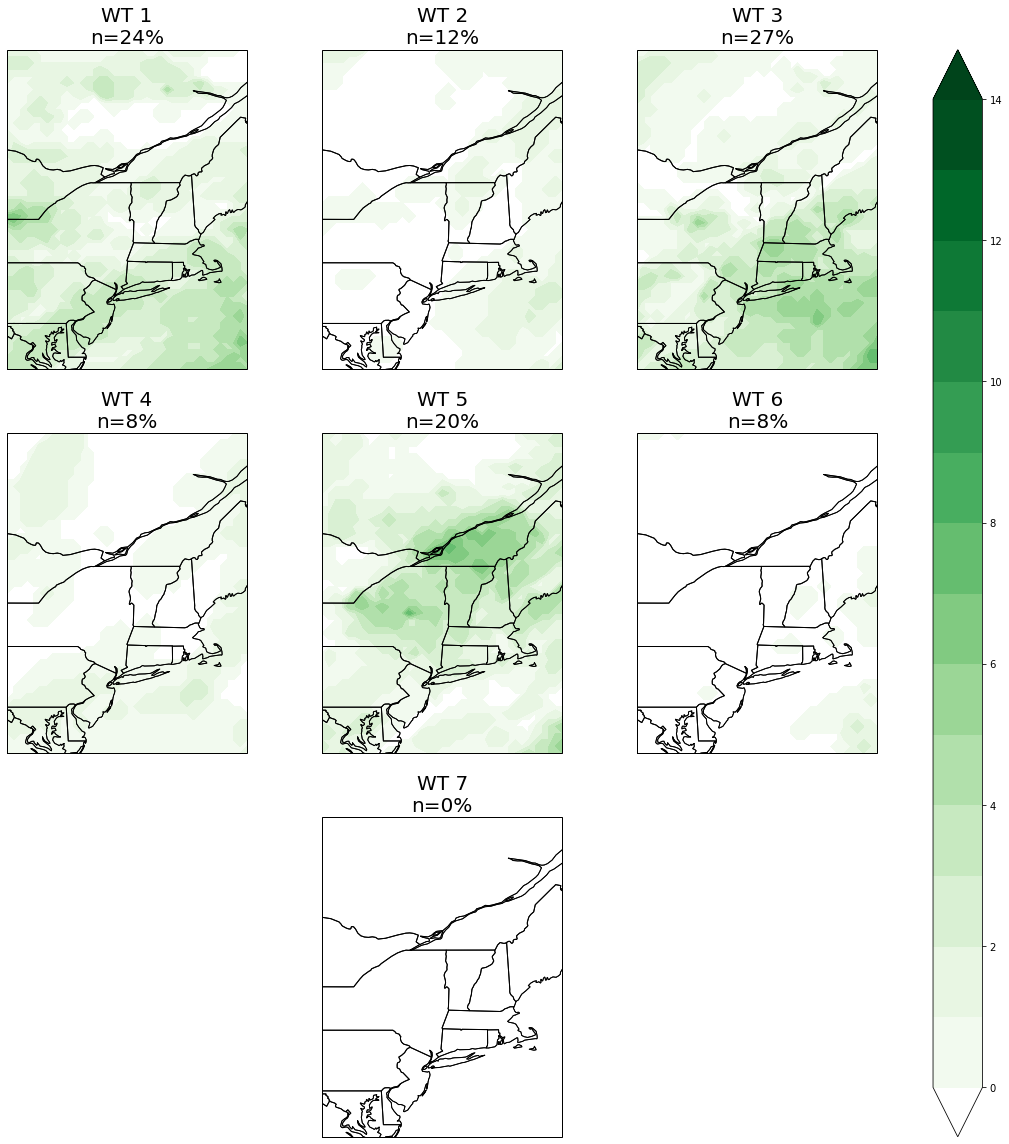

In [64]:
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from copy import copy
fig = plt.figure(figsize=(8, 8))
i = 1

#percents for labels
percents = []
[percents.append((round(cluster.count(a)/len(cluster)*100,0))) for a in range(1,8) ]

axlist = make_grid(3,3,cbar=False)
while i <= 7:
    # WT = precip_data[[j for j, val in enumerate(flat_list) if val == i]]
    # LON2, LAT2 = np.meshgrid(lons2, lats2)
    if(i != 7):
        ax = axlist[i-1]
    else:
        ax = axlist[i]
    ax.set_extent([-78, -69, 38, 50])
    ylocs = np.arange(30, 50, 5)
    xlocs = np.arange(280, 300, 10)

    # Load in the data using xarray

    #overall_heatwavedays[overall_heatwavedays == 0] = np.nan
    palette = copy(plt.get_cmap('Greens'))
    palette.set_under('white', 1.0)
    cs = ax.contourf(LON, LAT, overall_xpdays[i-1,:,:], levels = np.arange(0,15,1), extend = 'both', cmap=palette, transform=ccrs.PlateCarree())
    
    states = NaturalEarthFeature(category = 'cultural',
                     scale = '50m',
                     facecolor = 'none',
                     name = 'admin_1_states_provinces_shp')
    ax.add_feature(states,linewidth=1.,edgecolor="black")
    ax.coastlines('50m',linewidth=0.8)
    #ax.gridlines(linestyle='dotted', ylocs=lats[::20], xlocs=lons[::20])


    if(i == 1):
        wtt = 1
    elif(i == 2):
        wtt = 2
    elif( i == 3):
        wtt = 3
    elif(i == 4):
        wtt = 4
    elif(i == 5):
        wtt = 5
    elif( i == 6):
        wtt = 6
    else:
        wtt = 7
        
    #plt.rc('text', usetex=True)
    tit1 = 'WT ' + str(wtt)
    tit2 = "n=" + str(int(percents[i-1])) + "%"
    #title = r'\fontsize{20pt}{3em}\selectfont{}{WT\r}{\fontsize{18pt}{3em}\selectfont{}(September 16 - October 30, 2012)}'
    title = tit1 + "\n" + tit2
    ax.set_title(title, fontsize=20)
    i += 1
plt.colorbar(cs, ax=axlist[:], orientation='vertical', shrink=1.0)
axlist[6].set_visible(False)
axlist[8].set_visible(False)
plt.savefig('extremeprecip.png',bbox_inches='tight')

In [54]:
overall_xpdays

array([[[0., 0., 0., ..., 2., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [2., 2., 1., ..., 0., 0., 0.],
        [2., 2., 2., ..., 0., 0., 0.],
        [2., 2., 2., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 1.],
        [0., 0., 0., ..., 2., 1., 1.],
        ...,
        [2., 2., 3., ..., 1., 1., 2.],
        [3., 3., 4., ..., 1., 2., 2.],
        [2., 3., 3., ..., 2., 2., 2.]],

       [[1., 1., 1., ..., 0., 0., 1.],
        [1., 1., 1., ..., 0., 1., 1.],
        [1., 1., 1., ..., 0., 1., 2.],
        ...,
        [2., 2., 2., ..., 2., 2., 3.],
        [2., 2., 2., ..., 2., 3., 4.],
        [2., 3., 3., ..., 3., 4., 4.]],

       ...,

       [[0., 0., 0., ..., 1., 2., 2.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0.

In [55]:
len(clustvals[364:])

3276